## Import & Setup

Note, if you are getting errors like this:
```
...
from .extension import *
  File ".../isaacsim/extsUser/go4robo/go4robo_python/extension.py", line 3, in <module>
    import omni.ext
ModuleNotFoundError: No module named 'omni'
```

Go into `isaacsim/extsUser/go4robo/go4robo_python/__init__.py` and comment out the following line:
```
from .extension import *
```

!! You need to uncomment this line if you plan to run the Isaac Sim extension !!

In [124]:
#Enable reloading because restarting the kernel is a pain
%load_ext autoreload
%autoreload 2

%pip install -q usd-core
%pip install -q pymoo

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np

from isaacsim.extsUser.go4robo.go4robo_python.bot_3d_problem import *
from isaacsim.extsUser.go4robo.go4robo_python.bot_3d_rep import *

import json

import os, sys

import copy

import plotly.graph_objects as go
import seaborn as sns
import pandas as pd

from tqdm.notebook import trange, tqdm

sns.set_style("whitegrid")
sns.set_palette("husl")
sns.set_context("notebook", font_scale=1.5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Put the run ID here

In [125]:
run_id = "20250503_144341"

## Get the generated designs from csv

In [126]:
df_csv_path = f"/home/rachael/Documents/GitHub/go4robo/isaacsim/extsUser/go4robo/go4robo_python/results/designs_Robot_{run_id}.csv" # This should also contain the prior design at index 0

df = pd.read_csv(df_csv_path)
df

id          Name  Cost  Perception Entropy  Generation  s0_type  \
0          0  Prior Design   1.0            8.091678           0        1   
1          1      Design 1   1.0            8.172121           1        1   
2          2      Design 2   1.0           17.102970           1        1   
3          3      Design 3   2.0           17.102970           1        1   
4          4      Design 4   2.0            9.989696           1        1   
...      ...           ...   ...                 ...         ...      ...   
34926  34926  Design 34926   1.0            1.651555         499        1   
34927  34927  Design 34927   1.0            1.651555         499        1   
34928  34928  Design 34928   1.0            1.651555         499        1   
34929  34929  Design 34929   1.0            1.651555         499        1   
34930  34930  Design 34930   1.0            1.651555         499        1   

           s0_x      s0_y      s0_z     s0_qw  ...  s3_qy  s3_qz  s4_type  \
0      0.000000  0.000000  0.500000  1.000000  ...    0.0    0.0        0   
1      0.770239  0.731729  0.259698  0.334705  ...    0.0    0.0        0   
2      0.636604  0.993913  0.546071 -0.413835  ...    0.0    0.0        0   
3      0.441904  0.581577  0.989752 -0.326462  ...    0.0    0.0        0   
4      0.843840  0.381016  0.749858  0.036272  ...    0.0    0.0        0   
...         ...       ...       ...       ...  ...    ...    ...      ...   
34926  0.999665  0.396513  0.944043  0.802237  ...    0.0    0.0        0   
34927  0.999664  0.396513  0.944043  0.802234  ...    0.0    0.0        0   
34928  0.999657  0.396513  0.944043  0.802235  ...    0.0    0.0        0   
34929  0.999657  0.396513  0.944043  0.802235  ...    0.0    0.0        0   
34930  0.999651  0.396513  0.944043  0.802235  ...    0.0    0.0        0   

       s4_x  s4_y  s4_z  s4_qw  s4_qx  s4_qy  s4_qz  
0       0.0   0.0   0.0    0.0    0.0    0.0    0.0  
1       0.0   0.0   0.0    0.0    0.0    0.0    0.0  
2       0.0   0.0   0.0    0.0    0.0    0.0    0.0  
3       0.0   0.0   0.0    0.0    0.0    0.0    0.0  
4       0.0   0.0   0.0    0.0    0.0    0.0    0.0  
...     ...   ...   ...    ...    ...    ...    ...  
34926   0.0   0.0   0.0    0.0    0.0    0.0    0.0  
34927   0.0   0.0   0.0    0.0    0.0    0.0    0.0  
34928   0.0   0.0   0.0    0.0    0.0    0.0    0.0  
34929   0.0   0.0   0.0    0.0    0.0    0.0    0.0  
34930   0.0   0.0   0.0    0.0    0.0    0.0    0.0  

[34931 rows x 45 columns]

## Plot the tradespace

Conveniently you can do this without the Problem definition, assuming you used the standard problem definition.

In [127]:
plot_tradespace(df)

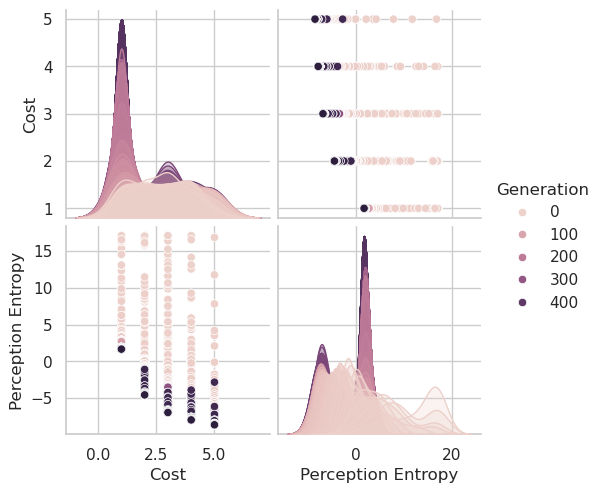

In [128]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1)

pair_plot_df = df[["Generation", "Cost", "Perception Entropy"]]
sns.pairplot(pair_plot_df, hue="Generation", diag_kind="kde")


## Set up the problem from json

In [129]:
json_prolem_path = f"/home/rachael/Documents/GitHub/go4robo/isaacsim/extsUser/go4robo/go4robo_python/results/problem_Robot_{run_id}.json" # This will contain the prior design at problem.prior_bot

problem_json_dict = json.load(open(json_prolem_path, 'r'))

problem = SensorPkgOptimization.from_json(problem_json_dict)

prior_bot_from_problem = problem.prior_bot

## Plot any bot from the df above

### Put the design of interest here

In [156]:
INDEX_TO_PLOT = 34930

In [157]:
from plotly.subplots import make_subplots

design_x_dict = df[df["id"] == INDEX_TO_PLOT].iloc[0].to_dict()
bot_x = problem.convert_1D_to_bot(design_x_dict)
design_x_fig = bot_x.plot_bot_3d(
    perception_space=problem.perception_space,
    show=False,
    width=600,
)

design_0_dict = df[df["id"] == 0].iloc[0].to_dict()
bot_0 = problem.convert_1D_to_bot(design_0_dict)
design_0_fig = bot_0.plot_bot_3d(
    perception_space=problem.perception_space,
    show=False,
    width=600,
)

combined_fig = make_subplots(rows=1, cols=2, specs=[[{"type": "scene"}, {"type": "scene"}]])
for trace in design_0_fig.data:
    combined_fig.add_trace(trace, row=1, col=1)
for trace in design_x_fig.data:
    combined_fig.add_trace(trace, row=1, col=2)

combined_fig.update_layout(
    title_text=f"Design 0 (PE:{design_0_dict["Perception Entropy"]:.2f}) vs Design {INDEX_TO_PLOT} (PE:{design_x_dict["Perception Entropy"]:.2f})",
    showlegend=False,
    width=1200,
    height=600,
)

# combined_fig.show()
design_0_fig.show()
design_x_fig.show()

Found sensor type 1 in problem sensor options.
Found sensor type 1 in problem sensor options.


In [158]:
sensor_0:Sensor3D_Instance = problem.prior_bot.sensors[0]

fig_0 = sensor_0.plot_rays(*sensor_0.get_rays(verbose=True), show=False, ray_length=2)

for trace in design_0_fig.data:
    fig_0.add_trace(trace)

fig_0

Calculating rays for <class 'isaacsim.extsUser.go4robo.go4robo_python.bot_3d_rep.Sensor3D_Instance'> s0=Lidar_A, with 1 sets of rays...
 Sensor 0: Lidar_A, is a (<class 'isaacsim.extsUser.go4robo.go4robo_python.bot_3d_rep.Lidar3D'>)
  POS:  [0.0, 0.0, 0.5]
  QUAT: [1.0, 0.0, 0.0, 0.0] (w,x,y,z)
  R:    [1. 0. 0.]
        [0. 1. 0.]
        [0. 0. 1.]
  H_ANGLES: shape=torch.Size([224]), min=-1.5707963705062866, max=1.5707963705062866
  V_ANGLES: shape=torch.Size([7]), min=-0.2617993950843811, max=0.2617993950843811
  H_GRID: shape=torch.Size([7, 224]), min=-1.5707963705062866, max=1.5707963705062866
  V_GRID: shape=torch.Size([7, 224]), min=-0.2617993950843811, max=0.2617993950843811
  +X: tensor([-4.2222e-08,  1.3607e-02,  2.7212e-02,  ...,  2.7212e-02,
         1.3607e-02, -4.2222e-08], device='cuda:0')
  +Y: tensor([-0.9659, -0.9658, -0.9655,  ...,  0.9655,  0.9658,  0.9659],
       device='cuda:0')
  +Z: tensor([-0.2588, -0.2588, -0.2588,  ...,  0.2588,  0.2588,  0.2588],
       de

In [159]:
sensor_x:Sensor3D_Instance = bot_x.sensors[0]

fig_x = sensor_x.plot_rays(*sensor_x.get_rays(verbose=True), show=False, ray_length=2)

for trace in design_x_fig.data:
    fig_x.add_trace(trace)

fig_x

Calculating rays for <class 'isaacsim.extsUser.go4robo.go4robo_python.bot_3d_rep.Sensor3D_Instance'> sensor_0, with 1 sets of rays...
 Sensor 0: Lidar_A, is a (<class 'isaacsim.extsUser.go4robo.go4robo_python.bot_3d_rep.Lidar3D'>)
  POS:  (0.9996507105568, 0.3965133496304915, 0.9440425461687756)
  QUAT: (0.8022345304489136, 0.2996615767478943, 0.2018665969371795, -0.4752605259418487) (w,x,y,z)
  R:    [0.46675462 0.88352414 0.03905407]
        [-0.64155749  0.36866074 -0.67267618]
        [-0.60872335  0.28891928  0.73890563]
  H_ANGLES: shape=torch.Size([224]), min=-1.5707963705062866, max=1.5707963705062866
  V_ANGLES: shape=torch.Size([7]), min=-0.2617993950843811, max=0.2617993950843811
  H_GRID: shape=torch.Size([7, 224]), min=-1.5707963705062866, max=1.5707963705062866
  V_GRID: shape=torch.Size([7, 224]), min=-0.2617993950843811, max=0.2617993950843811
  +X: tensor([-4.2222e-08,  1.3607e-02,  2.7212e-02,  ...,  2.7212e-02,
         1.3607e-02, -4.2222e-08], device='cuda:0')
  +Y

## Random Testing

### Ray/Voxel Traversal (measurement) test case

In [160]:
ro, rd = torch.tensor([[0.0, 0.0, 0.0],[0.0, 0.0, 0.0],[0.0, 0.0, 0.0]]), torch.tensor([[1.0, 0.0, 0.0],[0.0, 1.0, 0.0],[np.sqrt(0.5), np.sqrt(0.5), 0.0]])

simple_perception_space = PerceptionSpace(usd_context=None,
                                          voxel_groups=[PerceptionSpace.VoxelGroup(
                                                name="simple",
                                                voxels=['','','',''],
                                                voxel_centers=torch.tensor([
                                                    [-0.5, -0.5, 0.0],  # Behind the sensor, should have 0 hits
                                                    [0.0, 0.0, 0.0],    # At center of sensor, should have 3 hits
                                                    [0.5, 0, 0.0],      # Along x-axis, should have 1 hit
                                                    [1.0, 0.5, 0.0]     # Should have 0 hits
                                                    ]),
                                                voxel_sizes=torch.tensor([0.1,0.1,0.1,0.1]).unsqueeze(1),
                                          )
                                          ],
                                          weights=[1.0]
)

simple_sensor:Sensor3D_Instance = Sensor3D_Instance(
    sensor=Sensor3D(
        name="simple_sensor",
    ),
    path='',
    tf=((0, 0, 0), (1, 0, 0, 0)),
    name="simple_sensor_instance",
)
    

# display(torch.tensor([[1.0, 0, 0.5],[2.0, 0, 0.5]]).size())
# display(torch.tensor([0.5,0.5]).size())

one_ray_fig = simple_perception_space.plot_me(show=False, mode='boxes')
simple_sensor.plot_rays(ro, rd, show=False, fig=one_ray_fig, ray_length=1.25)


one_ray_fig

In [161]:
simple_perception_space.chunk_ray_voxel_intersections(ro, rd, verbose=True)
# simple_perception_space.batch_ray_voxel_intersections(ro, rd, verbose=True)

 Batch ray voxel intersection traversal took 0.00 seconds for 3 rays and 4 voxels.
  VOXEL HITS max: 3, min: 0


tensor([0, 3, 1, 0], device='cuda:0')